In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *



astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 2048  # object size in each dimension

noise = 0
z1c = -20e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
npos = 3  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/coded_apertures_2d'

## Read data

In [3]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts_code = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]



/data2/vnikitin/coded_apertures_2d/data/data_0_2048_1_3_-0.02_0_code.tiff


# Construct operators


In [4]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        
        # shift and crop the code 
        coder = S(coder, shifts_code[:, i])
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]

        # multiply by the probe
        coder *= prbr

        # propagate both to the sample plane
        coder = G(coder, wavelength, voxelsize, distances2[i])
        
        # multiply by the sample
        psir *= coder           

        # propagate all to the detector
        psir = G(psir, wavelength, voxelsize, distances[i])

        # unpad
        data[:, i] = psir[:, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2, psir.shape[1]//2-n//2:psir.shape[1]//2+n//2]
    return data

@gpu_batch
def _adj_holo(data, shifts_code, prb, code):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        prbr = cp.tile(prb,[psi.shape[0],1,1])        
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        psir = GT(psir, wavelength, voxelsize, distances[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:,ne-n//2-pad:ne+n//2+pad,ne-n//2-pad:ne+n//2+pad]        
        coder *= prbr
        coder = G(coder, wavelength, voxelsize, distances2[j])
        psir *= cp.conj(coder)
        psi += psir
    return psi

@gpu_batch
def _adj_holo_prb(data, shifts_code, psi, code):
    psi = cp.array(psi)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)       
    prb = cp.zeros([data.shape[0], n+2*pad, n+2*pad], dtype='complex64')
    for j in range(npos):
        prbr = np.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))
        coder = cp.tile(code,[psi.shape[0],1,1])
        psir = psi.copy()
        prbr = GT(prbr, wavelength, voxelsize, distances[j])
        prbr*=cp.conj(psir)
        prbr = GT(prbr, wavelength, voxelsize, distances2[j])
        coder = S(coder, shifts_code[:,j])            
        coder = coder[:, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad, coder.shape[1]//2-n//2-pad:coder.shape[1]//2+n//2+pad]
        prbr *= cp.conj(coder)
        prb += prbr
    return prb

def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)
def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, prb, code)
def adj_holo_prb(data, psi):
    ''' Adjoint Holography operator '''
    return np.sum(_adj_holo_prb(data, shifts_code, psi, code), axis=0)[np.newaxis]

# adjoint tests
data = data00.copy()
arr1 = cp.pad(cp.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')

prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
code = cp.array(code)
shifts_code = cp.array(shifts_code)
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)
arr4 = adj_holo_prb(arr2, arr1)

print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(prb1*cp.conj(arr4))}==\n{cp.sum(arr2*cp.conj(arr2))}')

(28913050-0.03271484375j)==
(28913048-2.8889735403936356e-05j)
(28913048-0.890625j)==
(28913048-2.8889735403936356e-05j)


### Propagate the code to the detector and divide all data by it

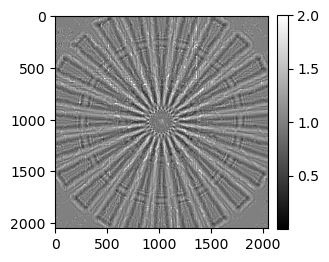

In [5]:
psi = cp.ones([1,ne,ne],dtype='complex64')
prb = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
ref0 = cp.array(ref0)
data00 = cp.array(data00)
d = cp.abs(fwd_holo(psi,prb))**2

rdata = data00/d/ref0
mshow((rdata)[0,0],show,vmax=2)

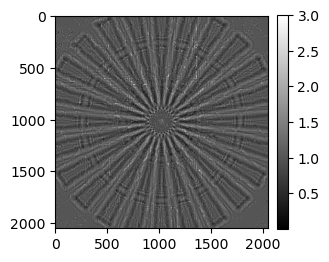

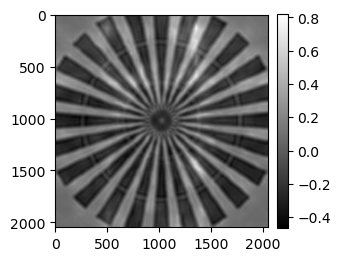

In [6]:
# print(pad)
#rdata0 = np.pad(rdata,((0,0),(0,0),(pad,pad),(pad,pad)),'symmetric')
mshow(rdata[0,0],show,vmax=3)
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances, wavelength, voxelsize,  19, 1e-12))#[:,pad:-pad,pad:-pad]
mshow(np.angle(recMultiPaganin[0]),show)

#### Reconstruction with the CG

0) gamma=0.5, err=3.41893e+04


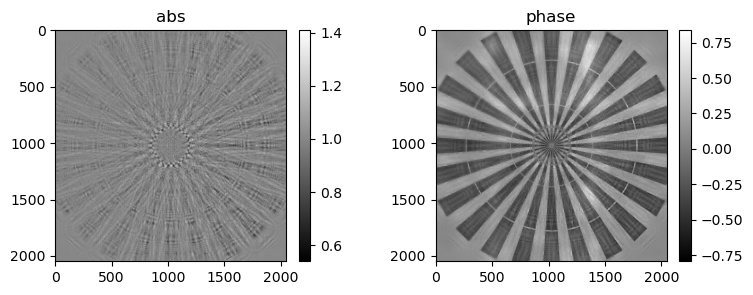

16) gamma=0.25, err=2.93698e+02
32) gamma=0.5, err=1.12917e+02


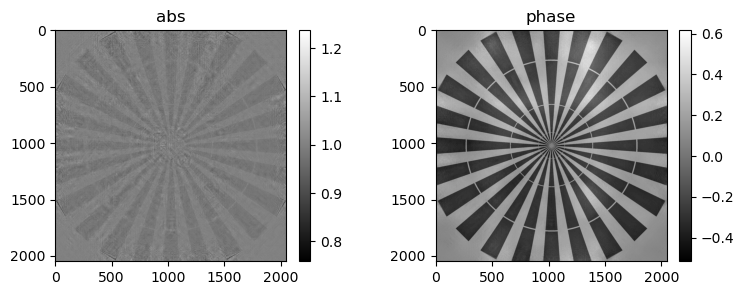

48) gamma=0.25, err=6.23499e+01
64) gamma=0.5, err=4.50879e+01


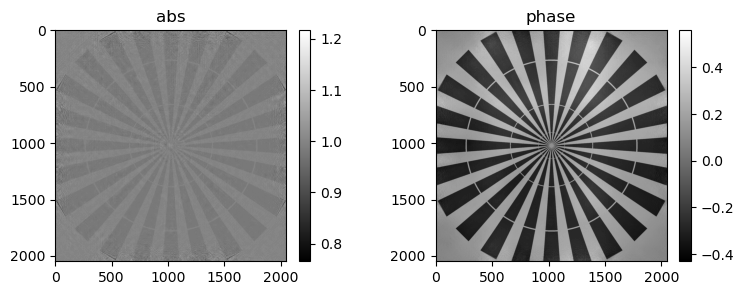

80) gamma=0.5, err=3.23325e+01
96) gamma=0.5, err=2.44003e+01


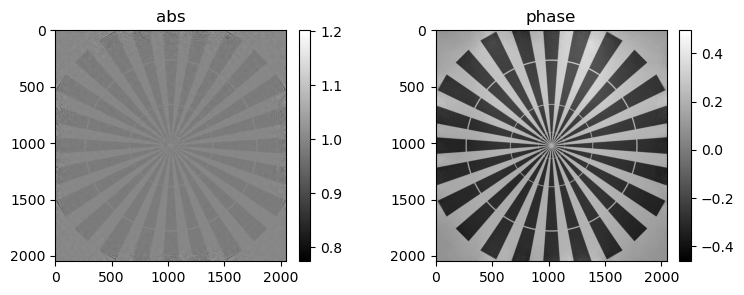

112) gamma=0.25, err=1.92910e+01
128) gamma=0.25, err=1.64261e+01


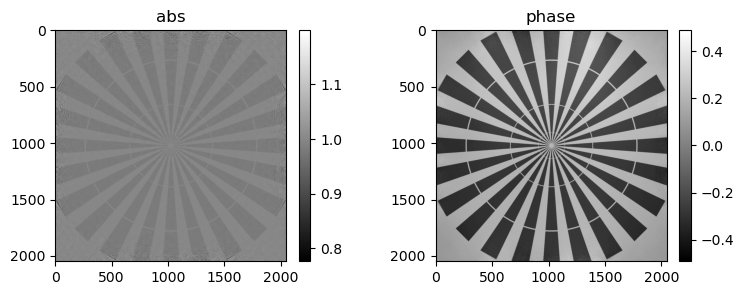

144) gamma=0.5, err=1.34517e+01
160) gamma=0.25, err=1.11575e+01


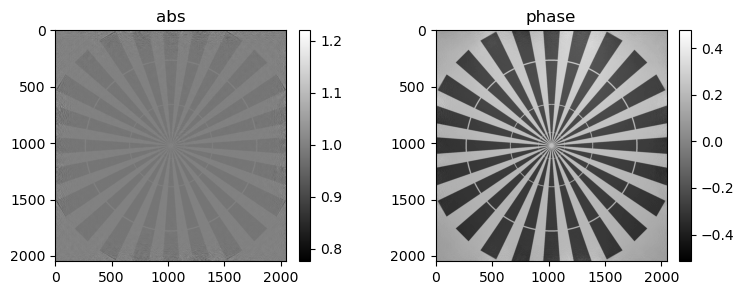

176) gamma=0.5, err=9.95941e+00
192) gamma=0.25, err=8.27134e+00


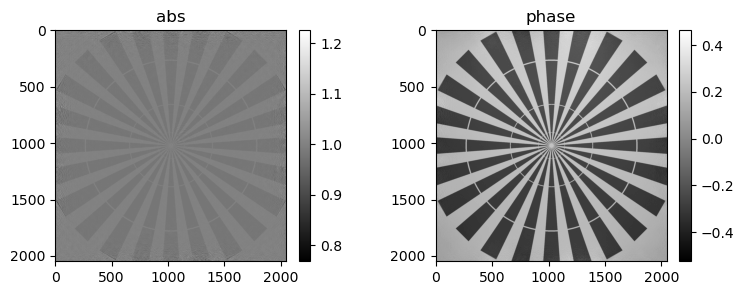

208) gamma=0.25, err=7.49432e+00
224) gamma=0.25, err=6.80230e+00


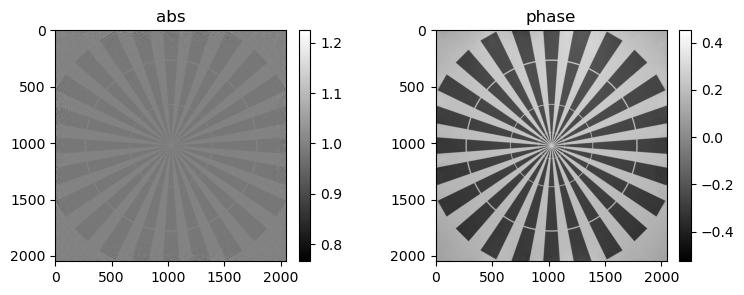

240) gamma=0.5, err=6.29738e+00
256) gamma=0.25, err=5.85587e+00


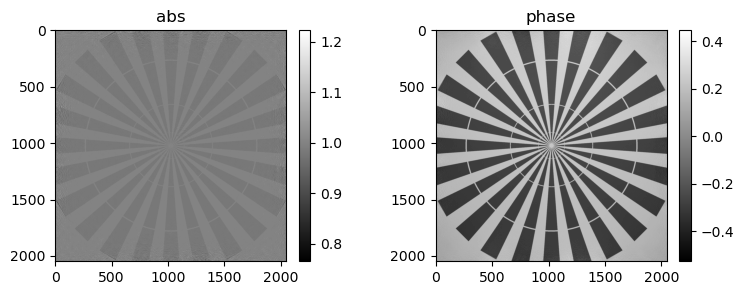

: 

In [9]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


def cg_holo(data, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    psi = init_psi.copy()
    prb = init_prb.copy()

    for i in range(pars['niter']):
        fpsi = fwd_holo(psi,prb)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)),prb)

        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d,prb)
        gamma = line_search(minf, pars['gammapsi'], fpsi, fd)
        psi += gamma*d

        if i % pars['err_step'] == 0:
            fpsi = fwd_holo(psi,prb)
            err = minf(fpsi)
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0,pad:-pad,pad:-pad],show)
            #mshow_polar(psi[0,ne//2-ne//16:ne//2+ne//16,ne//2-ne//16:ne//2+ne//16],show)

    return psi

# fully on gpu
rec_psi = cp.array(np.pad(recMultiPaganin,((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'edge'))
data = cp.array(data00.copy())

rec_prb = np.load(f'{path}/data/prb_{flg}.npy')

pars = {'niter': 257, 'err_step': 16, 'vis_step': 32, 'gammapsi':0.5}
rec_psi = cg_holo(data, rec_psi,rec_prb, pars)